# LASSO Regression

From [http://openonlinecourses.com/causalanalysis/LASSO.asp](http://openonlinecourses.com/causalanalysis/LASSO.asp).

In [1]:
import pandas as pd
import numpy as np

drop_cols = [
    'pub', 'WhytestedOther',
    'symptomsfirst', 
    'exposed', 'flushotlast',
    'exp1', 'exp2', 'exp3', 'exp4', 'exp5', 'exp6', 
    'exp7', 'exp8', 'exp9', 'exp10', 'exp11', 'exp12',
    'COVIDstigma1',
    'COVIDstigma2', 'COVIDstigma3', 'COVIDstigma4', 'COVIDstigma5',
    'COVIDstigma6', 'COVIDstigma7', 'COVIDstigma8', 'appknwldg',
    'appcurrent', 'appinterest', 'appwhy', 'appwhynot',
    'COVIDvaccine',
    'vaccine1', 'vaccine2', 'vaccine3', 'vaccine4', 'vaccineinfo',
    'Unnamed: 63', 'Unnamed: 66',
    'explasttime1=>10', 'explasttime2=<10', 'explasttime3=>50',
    'explasttime4=publictrans', 'explasttime5=airplane',
    'explasttime6=cruise', 'explasttime7=barcaferest',
    'explasttime8=grocery', 'explasttime9=retail', 'explasttime10=visit',
    'explasttime11=gym_team', 'explasttime12=rlgssvc', 'explasttime13=hcp'
]

yn = lambda v: np.nan if pd.isna(v) else 1 if v.lower() == 'yes' else 0

df = pd.read_excel('./D483.xlsx') \
    .drop(columns=drop_cols) \
    .assign(
        TestResult=lambda d: d['TestResult'].apply(lambda v: 1 if v == 'Yes, and I tested positive' else 0 if v == 'Yes, and I tested negative' else np.nan),
        Flutest=lambda d: d['Flutest'].apply(lambda v: 1 if v == 'Yes, and I tested positive' else 0),
        symptomsconsresp=lambda d: d['symptomsconsresp'].apply(lambda v: 0 if v == 'No' else 1 if v == 'Yes' else np.nan),
        symptomsconsgastro=lambda d: d['symptomsconsgastro'].apply(lambda v: 0 if v == 'No' else 1 if pd.notna(v) else np.nan),
        symptomsconsneuro=lambda d: d['symptomsconsneuro'].apply(lambda v: 0 if v == 'No' else 1 if pd.notna(v) else np.nan),
        symptomsconsinflamm=lambda d: d['symptomsconsinflamm'].apply(lambda v: 0 if v == 'No' else 1 if pd.notna(v) else np.nan),
        underlying=lambda d: d['underlying'].apply(lambda v: 0 if v == 'None' else 1),
        maskindoors=lambda d: d['maskindoors'].apply(lambda v: 0 if v.startswith('No') else 1 if v.startswith('Sometimes') else 2 if v.startswith('Yes') else np.nan),
        socialdist=lambda d: d['socialdist'].apply(lambda v: 0 if v.startswith('No') else 1 if v.startswith('Sometimes') else 2 if v.startswith('Yes') else np.nan),
        Race=lambda d: d['Race'].apply(lambda v: 1 if v == 'White' else 0 if pd.notna(v) else np.nan),
        Ethnicity=lambda d: d['Ethnicity'].apply(lambda v: 1 if v == 'Hispanic Latino' else 0 if pd.notna(v) else np.nan),
        gender=lambda d: d['gender'].apply(lambda v: 1 if v == 'Male' else 0 if v == 'Female' else np.nan),
        living=lambda d: d['living'].apply(lambda v: 1 if v.startswith('House') else 0 if pd.notna(v) else np.nan),
        ACE=lambda d: d['ACE'].apply(yn),
        prevCOVID=lambda d: d['prevCOVID'].apply(yn),
        foodpoison=lambda d: d['foodpoison'].apply(yn),
        flushot=lambda d: d['flushot'].apply(yn),
        healthcare=lambda d: d['healthcare'].apply(yn),
        essential=lambda d: d['essential'].apply(yn),
        state=lambda d: d['state'].apply(yn),
        countries=lambda d: d['countries'].apply(yn),
        children=lambda d: d['children'].apply(yn)
    )
df.shape

(483, 31)

In [2]:
df.columns

Index(['TestResult', 'Flutest', 'symptoms', 'symptomsresp', 'symptomsconsresp',
       'symptomsgastro', 'symptomsconsgastro', 'symptomsneuro',
       'symptomsconsneuro', 'symptomsinflamm', 'symptomsconsinflamm', 'ACE',
       'Bloodtype', 'underlying', 'overallhealth', 'prevCOVID', 'maskindoors',
       'socialdist', 'foodpoison', 'flushot', 'healthcare', 'essential',
       'state', 'countries', 'children', 'living', 'livingpeople', 'age',
       'Race', 'Ethnicity', 'gender'],
      dtype='object')

In [3]:
import itertools

clean_symptom_name = lambda n: n.replace('(', '').replace(')', '').replace('/', '').replace(' ', '_').lower()
parse_symptoms = lambda s: [] if pd.isna(s) else [] if s.startswith('None') else [clean_symptom_name(item) for item in s.split(',')]
get_symptoms = lambda f: list(set(itertools.chain(*df[f].apply(parse_symptoms))))

f2symptoms = {f: get_symptoms(f) for f in ['symptoms', 'symptomsresp', 'symptomsgastro', 'symptomsneuro', 'symptomsinflamm']}

for f, symptoms in f2symptoms.items():
    for s in symptoms:
        df[s] = df[f].apply(lambda v: np.nan if pd.isna(v) else 1 if s in parse_symptoms(v) else 0)

In [4]:
df.shape

(483, 61)

## One-way interaction

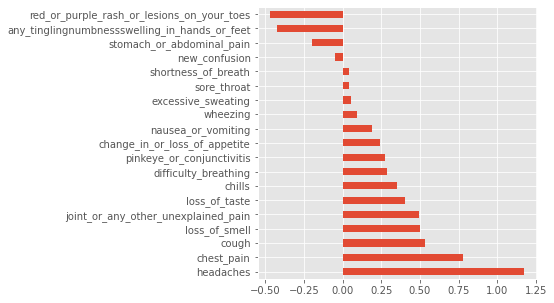

In [23]:
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

plt.style.use('ggplot')

symptom_fields = list(itertools.chain(*f2symptoms.values()))
formula = ' + '.join(symptom_fields)
formula = f'TestResult ~ ({formula})'

y, X = dmatrices(formula, df, return_type='dataframe')
y, X = np.ravel(y), X.iloc[:,1:]

model = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('regressor', LogisticRegression(C=0.5, penalty='l1', solver='saga', max_iter=5_000, random_state=37))
])

model.fit(X, y)

c = pd.Series(model.named_steps['regressor'].coef_[0], X.columns).sort_values(ascending=False)
c = c[abs(c) > 0]
c.plot(kind='barh', figsize=(5, 5));

## Two-way interaction

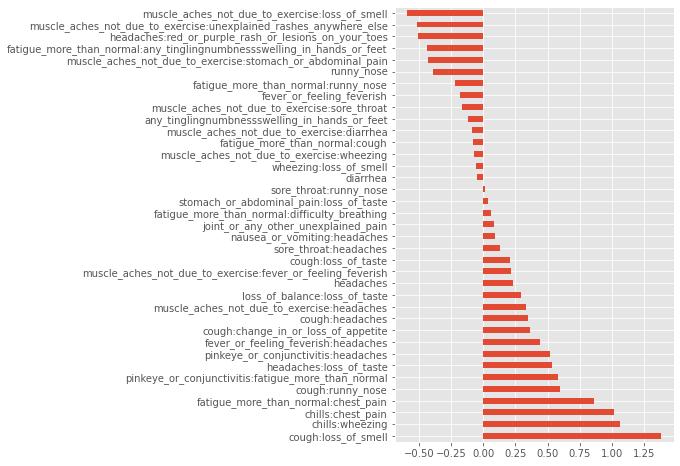

In [22]:
symptom_fields = list(itertools.chain(*f2symptoms.values()))
formula = ' + '.join(symptom_fields)
formula = f'TestResult ~ ({formula})**2'

y, X = dmatrices(formula, df, return_type='dataframe')
y, X = np.ravel(y), X.iloc[:,1:]

model = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('regressor', LogisticRegression(C=0.5, penalty='l1', solver='saga', max_iter=5_000, random_state=37))
])

model.fit(X, y)

c = pd.Series(model.named_steps['regressor'].coef_[0], X.columns).sort_values(ascending=False)
c = c[abs(c) > 0]
c.plot(kind='barh', figsize=(5, 8));

## Three-way interaction

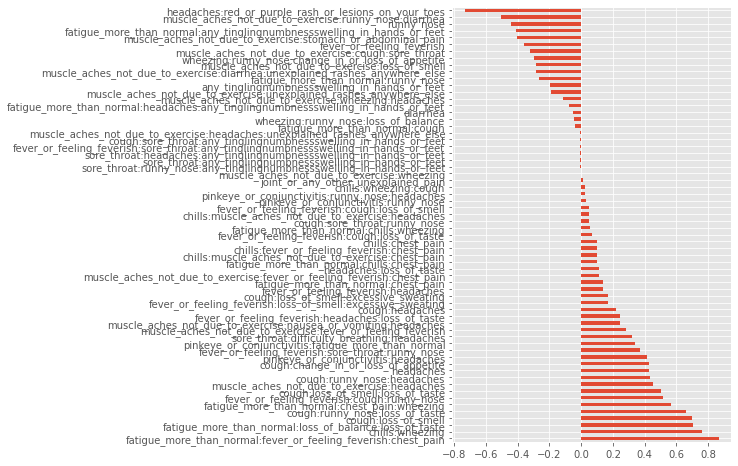

In [24]:
symptom_fields = list(itertools.chain(*f2symptoms.values()))
formula = ' + '.join(symptom_fields)
formula = f'TestResult ~ ({formula})**3'

y, X = dmatrices(formula, df, return_type='dataframe')
y, X = np.ravel(y), X.iloc[:,1:]

model = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('regressor', LogisticRegression(C=0.5, penalty='l1', solver='saga', max_iter=5_000, random_state=37))
])

model.fit(X, y)

c = pd.Series(model.named_steps['regressor'].coef_[0], X.columns).sort_values(ascending=False)
c = c[abs(c) > 0]
c.plot(kind='barh', figsize=(5, 10));

## Bonus

- regression on other variables (in addition to symptoms)